In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io
import cloudpickle as cpl
from collections import defaultdict
import os
from joblib import Parallel, delayed

lmap = lambda func, *iterable: list(map(func, *iterable))

In [3]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

cmap = LinearSegmentedColormap.from_list("CyanOrange", ["C0", "white", "C1"])
mpl.colormaps.register(cmap)

In [4]:
dataset_path = "/data/output/20220226_robustness/dataset.h5"

In [5]:
df_meta = pd.read_hdf(dataset_path, "meta")
df_meta.Robust = df_meta.Robust.apply(bool)

df_meta_sparse = pd.read_hdf(dataset_path, "meta_sparsity")
df_meta_pca = pd.read_hdf(dataset_path, "meta_pca")
df_meta_ortho = pd.read_hdf(dataset_path, "meta_ortho")
df_meta = pd.concat([df_meta, df_meta_sparse, df_meta_pca, df_meta_ortho], axis=1)

In [6]:
df_pairings = pd.read_csv("robust_vs_normal_pairings.csv", index_col=0)
all_used_model_names = pd.concat([df_pairings.Robust, df_pairings.Normal]).unique()

In [7]:
def agg_by_depth_decile_ortho(parent):
    agg = []
    for i, index in enumerate(parent.apply(lambda name: df_meta[df_meta.model == name].index)):
        df = df_meta.loc[index]
        df = df.reset_index()
        df.model_id = i
        df = df.set_index(["model_id", "conv_depth", "conv_depth_norm", "layer_id"])
        agg.append(df)
    selector = pd.concat(agg)
    
    grouper = lambda s: s.apply(lambda s: pd.Series({'result': (s["ortho"] * s["out_channels"]).sum() / s["out_channels"].sum()}))\
                        .groupby(level=0).result.apply(np.hstack)
    
    first = selector[selector.index.get_level_values("conv_depth") == 0]
    
    stack = []
    
    if len(first) > 0:
        stack.append(grouper(first.groupby(["conv_depth", "model_id"])))
    
    stack.append(grouper(selector.groupby([pd.cut(selector.index.get_level_values(2), np.linspace(0, 1, 11)), "model_id"])))
    
    return pd.concat(stack)

In [8]:
def agg_by_depth_decile_entropy(parent):
    agg = []
    for i, index in enumerate(parent.apply(lambda name: df_meta[df_meta.model == name].index)):
        df = df_meta.loc[index]
        df = df.reset_index()
        df.model_id = i
        df = df.set_index(["model_id", "conv_depth", "conv_depth_norm", "layer_id"])
        agg.append(df)
    selector = pd.concat(agg)
    
    grouper = lambda s: s.apply(lambda s: pd.Series({"result": (s["entropy"] * s["filter_ids"].apply(len)).sum() / (s["filter_ids"].apply(len)).sum()}))\
                        .groupby(level=0).result.apply(np.hstack)
    
    first = selector[selector.index.get_level_values("conv_depth") == 0]
    
    stack = []
    
    if len(first) > 0:
        stack.append(grouper(first.groupby(["conv_depth", "model_id"])))
    
    stack.append(grouper(selector.groupby([pd.cut(selector.index.get_level_values(2), np.linspace(0, 1, 11)), "model_id"])))
    
    return pd.concat(stack)

In [9]:
def agg_by_depth_decile_sparse(parent):
    agg = []
    for i, index in enumerate(parent.apply(lambda name: df_meta[df_meta.model == name].index)):
        df = df_meta.loc[index]
        df = df.reset_index()
        df.model_id = i
        df = df.set_index(["model_id", "conv_depth", "conv_depth_norm", "layer_id"])
        agg.append(df)
    selector = pd.concat(agg)
    
    grouper = lambda s: s.apply(lambda s: pd.Series({'result': s["layer_sparse_filters"].sum() / s["layer_num_filters"].sum()}))\
                        .groupby(level=0).result.apply(np.hstack)
    
    first = selector[selector.index.get_level_values("conv_depth") == 0]
    
    stack = []
    
    if len(first) > 0:
        stack.append(grouper(first.groupby(["conv_depth", "model_id"])))
    
    stack.append(grouper(selector.groupby([pd.cut(selector.index.get_level_values(2), np.linspace(0, 1, 11)), "model_id"])))
    
    return pd.concat(stack)

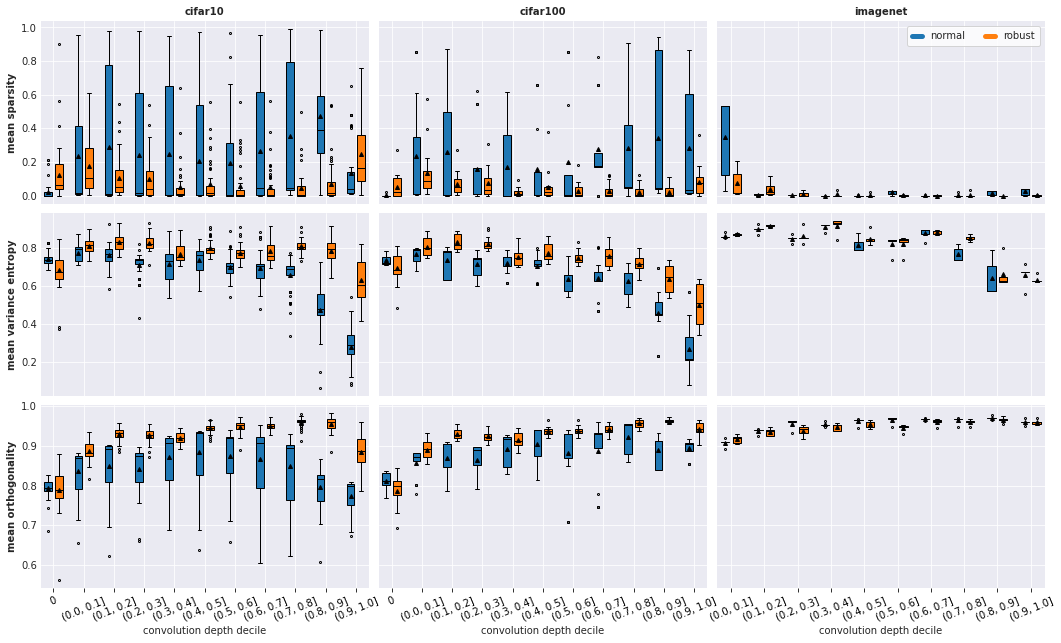

In [69]:
from boxplots import boxplots


with plt.style.context("seaborn-dark"):
    
    plt.rcParams['xtick.major.size'] = 3.5
    plt.rcParams['xtick.color'] = "black"
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 9), facecolor="white", sharey="row")
    
    axes[0,0].set_title("cifar10", fontsize = 10, fontweight ='bold')
    axes[0,1].set_title("cifar100", fontsize = 10, fontweight ='bold')
    axes[0,2].set_title("imagenet", fontsize = 10, fontweight ='bold')

    boxplots(
        [
            agg_by_depth_decile_sparse(df_pairings[df_pairings.Normal.str.contains("_cifar10_")].Normal),
            agg_by_depth_decile_sparse(df_pairings[df_pairings.Robust.str.contains("_cifar10_")].Robust),
        ], labels=["normal", "robust"], ax=axes[0,0], hide_ticks=True)

    boxplots(
        [
            agg_by_depth_decile_sparse(df_pairings[df_pairings.Normal.str.contains("_cifar100_")].Normal),
            agg_by_depth_decile_sparse(df_pairings[df_pairings.Robust.str.contains("_cifar100_")].Robust),
        ], labels=["normal", "robust"], ax=axes[0,1], hide_ticks=True)

    boxplots(
        [
            agg_by_depth_decile_sparse(df_pairings[df_pairings.Normal.str.contains("_imagenet1k_")].Normal),
            agg_by_depth_decile_sparse(df_pairings[df_pairings.Robust.str.contains("_imagenet_")].Robust),
        ], labels=["normal", "robust"], ax=axes[0,2], hide_ticks=True)

    boxplots(
        [
            agg_by_depth_decile_entropy(df_pairings[df_pairings.Normal.str.contains("_cifar10_")].Normal),
            agg_by_depth_decile_entropy(df_pairings[df_pairings.Robust.str.contains("_cifar10_")].Robust),
        ], labels=["normal", "robust"], ax=axes[1,0], hide_ticks=True)
    boxplots(
        [
            agg_by_depth_decile_entropy(df_pairings[df_pairings.Normal.str.contains("_cifar100_")].Normal),
            agg_by_depth_decile_entropy(df_pairings[df_pairings.Robust.str.contains("_cifar100_")].Robust),
        ], labels=["normal", "robust"], ax=axes[1,1], hide_ticks=True)
    boxplots(
        [
            agg_by_depth_decile_entropy(df_pairings[df_pairings.Normal.str.contains("_imagenet1k_")].Normal),
            agg_by_depth_decile_entropy(df_pairings[df_pairings.Robust.str.contains("_imagenet_")].Robust),
        ], labels=["normal", "robust"], ax=axes[1,2], hide_ticks=True)

    boxplots(
        [
            agg_by_depth_decile_ortho(df_pairings[df_pairings.Normal.str.contains("_cifar10_")].Normal),
            agg_by_depth_decile_ortho(df_pairings[df_pairings.Robust.str.contains("_cifar10_")].Robust),
        ], labels=["normal", "robust"], ax=axes[2,0])
    boxplots(
        [
            agg_by_depth_decile_ortho(df_pairings[df_pairings.Normal.str.contains("_cifar100_")].Normal),
            agg_by_depth_decile_ortho(df_pairings[df_pairings.Robust.str.contains("_cifar100_")].Robust),
        ], labels=["normal", "robust"], ax=axes[2,1])
    boxplots(
        [
            agg_by_depth_decile_ortho(df_pairings[df_pairings.Normal.str.contains("_imagenet1k_")].Normal),
            agg_by_depth_decile_ortho(df_pairings[df_pairings.Robust.str.contains("_imagenet_")].Robust),
        ], labels=["normal", "robust"], ax=axes[2,2])

    axes[0,0].set_ylabel("mean sparsity", fontsize = 10, fontweight ='bold')
    axes[1,0].set_ylabel("mean variance entropy", fontsize = 10, fontweight ='bold')
    axes[2,0].set_ylabel("mean orthogonality", fontsize = 10, fontweight ='bold')
    
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0, 0, 0.9, 1), ncol=3, fancybox=True, shadow=False, facecolor="white", framealpha=None, frameon=True, borderpad=0.5, handlelength=1)
    
    plt.subplots_adjust(wspace=0.03, hspace=0.05, top=1)

    plt.savefig("plots/metrics_normal_vs_robust.pdf", bbox_inches='tight')